In [88]:
import cv2
import glob
import pickle
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import center_of_mass
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm
from matplotlib.patches import Polygon
import os
import scipy as sp
from scipy import spatial as sps
import scipy.ndimage
from bbox.min_bounding_rect import minBoundingRect

def detect_hail_size(img, gsd, x0, y0, count, out_path=None):    
    #img = cv2.imread(file)
    #Convert image into HLS space
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #filename = Path(file).stem
    
    data = np.array(img_hls)
    origin=(x0,y0)
    polar_grid, rad, theta = reproject_image_into_polar(data, origin) 
    
    #Lightness value of center hail pixel
    L0 = img_hls[x0,y0,1]
    L0 = np.int64(L0)
    
    #Initialize edge coordinates
    edge_co = []
    
    #radial_co = []
    #Loop over all theta angles [RAD]
    for t, th in enumerate(theta):
        grad_L = []
        L_ra0 = []
        
        #Loop along polar radial pixels
        for r, ra in enumerate(rad):
            #if (p[0] > np.size(img,0)) or (p[1] > np.size(img,1)) or (p[0] < 0) or (p[1] < 0):
            #    continue
           
            L_ra0_tmp = polar_grid[r,t,1]
            L_ra0_tmp = np.int64(L_ra0_tmp)
            L_ra0.append(L_ra0_tmp)
            
            #Gradient to neighbor pixel
            L_ra1 = polar_grid[r+1,t,1]
            L_ra1 = np.int64(L_ra1)
            grad_L_tmp = np.gradient([L_ra0_tmp,L_ra1])
            grad_L.append(grad_L_tmp[0])

            if r == 0:
                continue
            else:
                if (np.abs(grad_L[r]) < 0.75 * np.abs(grad_L[r-1])) and (L0 - L_ra0_tmp > 50):
                    
                    for i in reversed(range(r+1)):
                        if (np.abs(grad_L[i-1]) < 0.75 * np.abs(grad_L[i])) and (L0 - L_ra0[i] < 50):
                            
                            #Save polar coordinates when condition is true
                            edge_co_tmp = (rad[i], th)
                            #edge_co_tmp = (ra, th)
                    
                            edge_co.append(edge_co_tmp)
                            break
                    break
                else:
                    continue
                    
    r_bt = np.array(edge_co)[:,0]
    th_bt = np.array(edge_co)[:,1]
    x,y = polar2cart(r_bt,th_bt)
    cart_co=[]
    for i, xval in enumerate(x):
        cart_co.append((xval+x0,y[i]+y0)) 

    (rot_angle, area, width, height, center_point, box) = minBoundingRect(np.asarray(cart_co))

    #Hail major axes and minor axes size from box
    major_size = np.max([width,height]) * gsd
    minor_size = np.min([width,height]) * gsd
    
    if out_path != None
        fig, ax = plt.subplots(figsize=[5,5])
        plt.scatter((x+x0),(y+y0),c='red')
        ax.plot(x0,y0,marker='x', color='red')
        plt.grid()
        plt.imshow(img_hls[:,:,1])

        #plot bounding box:
        ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
        ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
        ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
        ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
        ax.set_title('Major axes = '+str(np.round(major_size,2))+', Minor axes = '+str(np.round(minor_size,2)))
        plt.xlabel('PX')
        plt.ylabel('PX')
        plt.savefig(out_path+'hail_x'+str(np.int(x0))+'_y'+str(np.int(y0))+'.png',dpi=300,bbox_inches='tight')
        plt.close()
     
    return major_size, minor_size, x , y

def plot_directional_intensity(data, origin=None):
    """
    Makes a cicular histogram showing average intensity binned by direction
    from "origin" for each band in "data" (a 3D numpy array). "origin" defaults
    to the center of the image.
    
    Returns:
    None
    """
    def intensity_rose(theta, band, color):
        """
        Plot an intensity rose diagram for a given band at different angles.

        Parameters:
        - theta (numpy.ndarray): Array of angles (in radians) at which intensity values are measured.
        - band (numpy.ndarray): Array of intensity values corresponding to the given angles.
        - color (str): Color of the plotted bars in the intensity rose diagram.

        Returns:
        None: The function generates and displays an intensity rose diagram.
        """
        # Flatten input arrays for consistent handling
        theta, band = theta.flatten(), band.flatten()

        # Bin intensity values by angles
        intensities, theta_bins = bin_by(band, theta)

        # Calculate mean intensity for each bin
        mean_intensity = map(np.mean, intensities)

        # Calculate the width of each bar in the rose diagram
        width = np.diff(theta_bins)[0]

        # Plot the intensity rose diagram
        plt.bar(theta_bins, mean_intensity, width=width, color=color)
        plt.xlabel(color + ' Band')
        plt.yticks([])

    # Make cartesian coordinates for the pixel indicies
    # (The origin defaults to the center of the image)
    x, y = index_coords(data, origin)

    # Convert the pixel indices into polar coords.
    r, theta = cart2polar(x, y)

    # Unpack bands of the image
    red, green, blue = data.T

    # Plot...
    plt.figure()

    plt.subplot(2,2,1, projection='polar')
    intensity_rose(theta, red, 'Red')

    plt.subplot(2,2,2, projection='polar')
    intensity_rose(theta, green, 'Green')

    plt.subplot(2,1,2, projection='polar')
    intensity_rose(theta, blue, 'Blue')

    plt.suptitle('Average intensity as a function of direction')

def plot_polar_image(data, band=None, origin=None, size=[10,10]):
    """Plots an image reprojected into polar coordinages with the origin
    at "origin" (a tuple of (x0, y0), defaults to the center of the image)"""
    if band == None:
        band = 'l'
    if band == 'l':
        band_id = 1
        clab = 'Lightness value'
    elif band == 'h':
        band_id = 0
        clab = 'Hue value'
    elif band == 's':
        band_id = 2
        clab = 'Saturation value'
    polar_grid, r, theta = reproject_image_into_polar(data, origin)
    fig = plt.figure(figsize=size)
    pos = plt.imshow(polar_grid[:,:,band_id], extent=(theta.min(), theta.max(), r.max(), r.min()))
    plt.axis('auto')
    plt.ylim(plt.ylim()[::-1])
    cbar = fig.colorbar(pos)
    cbar.set_label(clab)
    plt.xlabel('Theta Coordinate (radians)')
    plt.ylabel('R Coordinate (pixels)')
    plt.title('Image in Polar Coordinates')

def index_coords(data, origin=None):
    """Creates x & y coords for the indicies in a numpy array "data".
    "origin" defaults to the center of the image. Specify origin=(0,0)
    to set the origin to the lower left corner of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin_x, origin_y = nx // 2, ny // 2
    else:
        origin_x, origin_y = origin
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x -= origin_x
    y -= origin_y
    return x, y

def cart2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y


def bin_by(x, y, nbins=30):
    """Bin x by y, given paired observations of x & y.
    Returns the binned "x" values and the left edges of the bins."""
    bins = np.linspace(y.min(), y.max(), nbins+1)
    # To avoid extra bin for the max value
    bins[-1] += 1 

    indicies = np.digitize(y, bins)

    output = []
    for i in range(1, len(bins)):
        output.append(x[indicies==i])

    # Just return the left edges of the bins
    bins = bins[:-1]

    return output, bins

def reproject_image_into_polar(data, origin=None):
    """Reprojects a 3D numpy array ("data") into a polar coordinate system.
    "origin" is a tuple of (x0, y0) and defaults to the center of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin = (nx//2, ny//2)

    # Determine that the min and max r and theta coords will be...
    x, y = index_coords(data, origin=origin)
    r, theta = cart2polar(x, y)

    # Make a regular (in polar space) grid based on the min and max r & theta
    r_i = np.linspace(r.min(), r.max(), nx)
    theta_i = np.linspace(theta.min(), theta.max(), ny)
    theta_grid, r_grid = np.meshgrid(theta_i, r_i)

    # Project the r and theta grid back into pixel coordinates
    xi, yi = polar2cart(r_grid, theta_grid)
    xi += origin[0] # We need to shift the origin back to 
    yi += origin[1] # back to the lower-left corner...
    xi, yi = xi.flatten(), yi.flatten()
    coords = np.vstack((xi, yi)) # (map_coordinates requires a 2xn array)

    # Reproject each band individually and the restack
    # (uses less memory than reprojection the 3-dimensional array in one step)
    bands = []
    for band in data.T:
        zi = sp.ndimage.map_coordinates(band, coords, order=1)
        bands.append(zi.reshape((nx, ny)))
    output = np.dstack(bands)
    return output, r_i, theta_i

in_path_img = '/home/martin/container/data/fake_hail/20220330_LOM/DJI_202203301504_019/Ref_JPG_pp3/'
out_path = '/home/martin/container/data/fake_hail/20220330_LOM/DJI_202203301504_019/Ref_JPG_pp3/products/polar/'

if not os.path.exists(out_path):
    os.makedirs(out_path)

all_ref = glob.glob(in_path_img+'*.png')
all_ref.sort()

In [58]:
all_ref[0]

'/home/martin/container/data/fake_hail/20220330_LOM/DJI_202203301504_019/Ref_JPG_pp3/10mm.png'

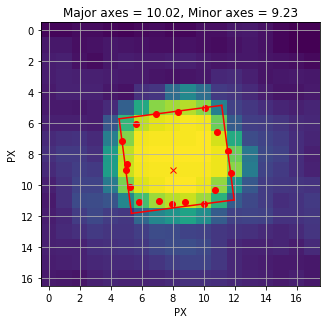

In [80]:
#for file in [all_ref[0]]:
for file in all_ref:    
    img = cv2.imread(file)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    filename = Path(file).stem
    
    #Define object pixel coordinates as center pixel of ref images
    x0 = np.int(np.size(img,0)/2)
    y0 = np.int(np.size(img,1)/2)
    
    #Manually set for test images when condition above is incorrect
    #x0=6
    #y0=6
    
    data = np.array(img_hls)
    origin=(x0,y0)
    polar_grid, rad, theta = reproject_image_into_polar(data, origin) 
    #print(np.shape(polar_grid))
    
    #Lightness value of center hail pixel
    L0 = img_hls[x0,y0,1]
    L0 = np.int64(L0)
    
    #print(L0)
    #print(polar_grid[0,0,1])
    #break
    
    #Initialize edge coordinates
    edge_co = []
    
    #radial_co = []
    #Loop over all theta angles [RAD]
    for t, th in enumerate(theta):
        grad_L = []
        L_ra0 = []
        
        #Loop along polar radial pixels
        for r, ra in enumerate(rad):
            #if (p[0] > np.size(img,0)) or (p[1] > np.size(img,1)) or (p[0] < 0) or (p[1] < 0):
            #    continue
            #else:    
                #Lightness value L of radial pixel
                #print(p)
            L_ra0_tmp = polar_grid[r,t,1]
            L_ra0_tmp = np.int64(L_ra0_tmp)
            L_ra0.append(L_ra0_tmp)
            
            #Gradient to neighbor pixel
            L_ra1 = polar_grid[r+1,t,1]
            L_ra1 = np.int64(L_ra1)
            grad_L_tmp = np.gradient([L_ra0_tmp,L_ra1])
            grad_L.append(grad_L_tmp[0])

            if r == 0:
                continue
            else:
                #print(grad_L)
                #if (np.abs(grad_L[r]) < 2 * np.abs(grad_L[r-1])) and (L0 - L_ra0 > 35):
                if (np.abs(grad_L[r]) < 0.75 * np.abs(grad_L[r-1])) and (L0 - L_ra0_tmp > 50):
                    
                    for i in reversed(range(r+1)):
                        if (np.abs(grad_L[i-1]) < 0.75 * np.abs(grad_L[i])) and (L0 - L_ra0[i] < 50):
                            
                            #Save polar coordinates when condition is true
                            edge_co_tmp = (rad[i], th)
                            #edge_co_tmp = (ra, th)
                    
                            edge_co.append(edge_co_tmp)
                            break
                    break
                else:
                    continue
                    
    r_bt = np.array(edge_co)[:,0]
    th_bt = np.array(edge_co)[:,1]
    x,y = polar2cart(r_bt,th_bt)
    xx=[]
    for i, xval in enumerate(x):
        xx.append((xval+x0,y[i]+y0)) 

    (rot_angle, area, width, height, center_point, box) = minBoundingRect(np.asarray(xx))

    gsd = 1.5 #1.5mm/pixel
    #Hail major axes and minor axes size from box
    major_size = np.max([width,height]) * gsd
    minor_size = np.min([width,height]) * gsd

    fig, ax = plt.subplots(figsize=[5,5])
    plt.scatter((x+x0),(y+y0),c='red')
    ax.plot(x0,y0,marker='x', color='red')
    plt.grid()
    plt.imshow(img_hls[:,:,1])

    #plot bounding box:
    ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
    ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
    ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
    ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
    ax.set_title('Major axes = '+str(np.round(major_size,2))+', Minor axes = '+str(np.round(minor_size,2)))
    plt.xlabel('PX')
    plt.ylabel('PX')
    plt.show()
    #plt.savefig(out_path+'2Co_v2_'+filename,dpi=300,bbox_inches='tight')
    #plt.close()

Text(0.5, 1.0, 'Major axes = 31.83, Minor axes = 30.35')

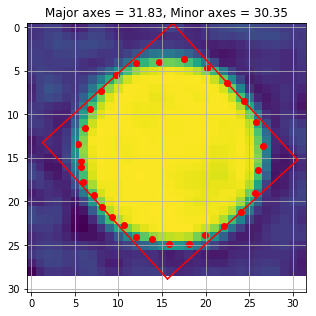

In [55]:
r_bt = np.array(edge_co)[:,0]
th_bt = np.array(edge_co)[:,1]
x,y = polar2cart(r_bt,th_bt)
xx=[]
for i, xval in enumerate(x):
    xx.append((xval+x0,y[i]+y0)) 

(rot_angle, area, width, height, center_point, box) = minBoundingRect(np.asarray(xx))

gsd = 1.5 #1.5mm/pixel
#Hail major axes and minor axes size from box
major_size = np.max([width,height]) * gsd
minor_size = np.min([width,height]) * gsd

fig, ax = plt.subplots(figsize=[5,5])
plt.scatter((x+x0),(y+y0),c='red')
plt.grid()
plt.imshow(img_hls[:,:,1])

#plot bounding box:
ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
ax.set_title('Major axes = '+str(np.round(major_size,2))+', Minor axes = '+str(np.round(minor_size,2)))

Text(0.5, 1.0, 'Major axes = 8.93, Minor axes = 7.8')

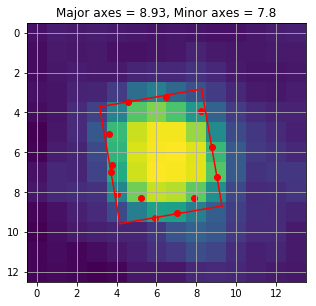

In [69]:
r_bt = np.array(edge_co)[:,0]
th_bt = np.array(edge_co)[:,1]
x,y = polar2cart(r_bt,th_bt)
xx=[]
for i, xval in enumerate(x):
    xx.append((xval+x0,y[i]+y0)) 

(rot_angle, area, width, height, center_point, box) = minBoundingRect(np.asarray(xx))

gsd = 1.5 #1.5mm/pixel
#Hail major axes and minor axes size from box
major_size = np.max([width,height]) * gsd
minor_size = np.min([width,height]) * gsd

fig, ax = plt.subplots(figsize=[5,5])
plt.scatter((x+x0),(y+y0),c='red')
plt.grid()
plt.imshow(img_hls[:,:,1])

#plot bounding box:
ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
ax.set_title('Major axes = '+str(np.round(major_size,2))+', Minor axes = '+str(np.round(minor_size,2)))

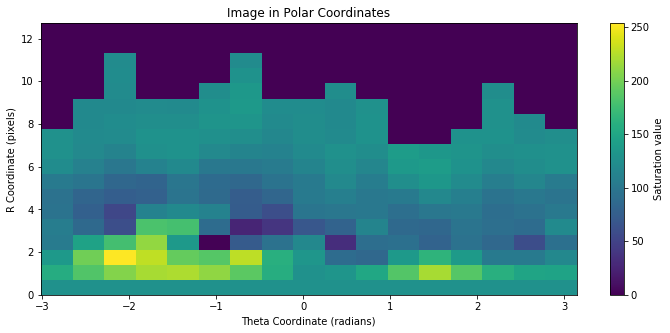

In [98]:
#img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
data = np.array(img_hls)

plot_polar_image(data,band='s', origin=(x0,y0),size=[12,5])
#plot_directional_intensity(data, origin=(x0,y0))
plt.show()


NameError: name 'filename' is not defined

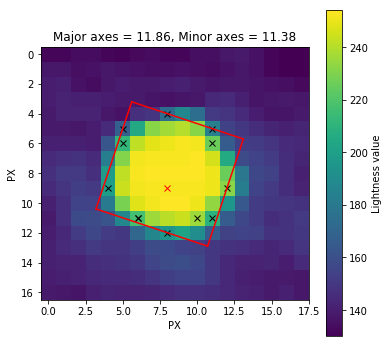

In [115]:
gsd = 1.5 #1.5mm/pixel
rect = minAreaRect(np.asarray(edge_co))
box = cv2.boxPoints(rect)

#Hail major axes and minor axes size from box
major_size = np.max(rect[1]) * gsd
minor_size = np.min(rect[1]) * gsd

#plot hls image
fig, ax = plt.subplots(figsize=[6,6])
#plot center pixel:
ax.plot(x0,y0,marker='x', color='red')
#plot edge points
pos = ax.imshow(img_hls[:,:,1],cmap='viridis',interpolation='none')
cbar = fig.colorbar(pos, ax=ax)
cbar.set_label('Lightness value')

for i in range(0,12):
    ax.plot(edge_co[i][0],edge_co[i][1], marker='x', color="black")
#plot bounding box:
ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
ax.set_title('Major axes = '+str(np.round(major_size,2))+', Minor axes = '+str(np.round(minor_size,2)))
plt.xlabel('PX')
plt.ylabel('PX')
plt.savefig(out_path+'V1'+filename,dpi=300,bbox_inches='tight')

In [111]:
plt.savefig?

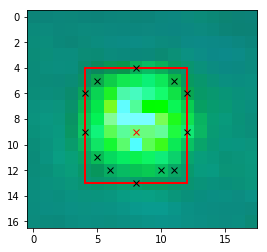

In [245]:
from matplotlib.patches import Rectangle
rect = minAreaRect(np.asarray(edge_co))
box = cv2.boxPoints(rect)
box = np.int0(box)
anchor_point = (rect[0][0] - rect[1][0]/2, rect[0][1] - rect[1][1]/2)

#plot hls image
fig, ax = plt.subplots()
#plot center pixel:
ax.plot(x0,y0,marker='x', color='red')
#plot edge points
ax.imshow(img_hls)
for i in range(0,12):
    plt.plot(edge_co[i][0],edge_co[i][1], marker='x', color="black")
#plot bounding box:
ax.add_patch(Rectangle(anchor_point, rect[1][0], rect[1][1], angle=rect[2],
             edgecolor = 'red',
             fill=False,
             lw=2))

In [197]:
def bbox(co):
    co = np.asarray(co)
    min_x, min_y = np.min(co[...,0]), np.min(co[...,1])
    max_x, max_y = np.max(co[...,0]), np.max(co[...,1])
    return np.array(
        [(min_x, min_y), (max_x, min_y), (max_x, max_y), (min_x, max_y)])

In [2]:
def spiral(X,Y):
    x = y = 0
    dx = 0
    dy = -1
    spiral = []
    for i in range(max(X, Y)**2):
        if (-X/2 < x <= X/2) and (-Y/2 < y <= Y/2):
            spiral.append((x, y))
        if x == y or (x < 0 and x == -y) or (x > 0 and x == 1-y):
            dx, dy = -dy, dx
        x, y = x+dx, y+dy
    return spiral

In [3]:
def create_radials(npix):
    radials = []
    tmp1 = []
    x = y = 0
    for i in range(0,npix):
        x = i
        y = y
        tmp1.append((x,y))

    tmp2 = []
    x = y = 0    
    for i in range(0,npix):
        x = x
        y = i
        tmp2.append((x,y))

    tmp3 = []
    x = y = 0    
    for i in range(0,npix):
        x = -i
        y = y
        tmp3.append((x,y))

    tmp4 = []
    x = y = 0    
    for i in range(0,npix):
        x = x
        y = -i
        tmp4.append((x,y))

    x1 = []
    y1 = []
    for i in range(0,np.int(npix)):
        x1.append(i)
        x1.append(i)
        x1.append(i)
        if i == 0:    
            y1.append(i)
        else:
            if i % 2:
                y1.append(-i)
            else:
                y1.append(-i)
                y1.append(-i)
                
    x1=x1[0:npix]            
    y1=y1[0:npix]
    #Correct radials
    #x1 = [0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6]
    #y1 = [0,-1,-2,-2,-3,-4,-4,-5,-6,-6,-7,-8,-8,-9,-10,-10,-11,-12,-12,-13]
    
    #Wrong radials
    #x1 = [0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10]
    #y1 = [0,0,-1,-1,-2,-2,-3,-3,-4,-4,-5,-5,-6,-6,-7,-7,-8,-8,-9,-9]
    
    
    tmp5 = []
    for i,v in enumerate(x1):
        tmp5.append((v,y1[i]))    

    x2 = np.asarray(y1) * -1
    y2 = np.asarray(x1) * -1
    tmp6 = []
    for i,v in enumerate(x2):
        tmp6.append((v,y2[i]))

    x3 = np.asarray(x1) * -1
    y3 = np.asarray(y1)
    tmp7 = []
    for i,v in enumerate(x3):
        tmp7.append((v,y3[i]))

    x4 = np.asarray(y1)
    y4 = np.asarray(x1) * -1
    tmp8 = []
    for i,v in enumerate(x4):
        tmp8.append((v,y4[i]))

    x5 = np.asarray(x1)
    y5 = np.asarray(y1) * -1
    tmp9 = []
    for i,v in enumerate(x5):
        tmp9.append((v,y5[i]))

    x6 = np.asarray(y1) * -1
    y6 = np.asarray(x1)
    tmp10 = []
    for i,v in enumerate(x6):
        tmp10.append((v,y6[i]))

    x7 = np.asarray(x1) * -1 
    y7 = np.asarray(y1) * -1
    tmp11 = []
    for i,v in enumerate(x7):
        tmp11.append((v,y7[i]))

    x8 = np.asarray(y1)
    y8 = np.asarray(x1)
    tmp12 = []
    for i,v in enumerate(x8):
        tmp12.append((v,y8[i]))
    
    radials = [tmp1,tmp2,tmp3,tmp4,tmp5,tmp6,tmp7,tmp8,tmp9,tmp10,tmp11,tmp12]
    
    return radials

In [ ]:
#Test with 12 radials - not so good results 
for file in [all_ref[9]]:
    img = cv2.imread(file)
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    filename = Path(file).stem
    
    #Define object pixel coordinates as center pixel of ref images
    x0 = np.int(np.size(img,0)/2)
    y0 = np.int(np.size(img,1)/2)
    
    #Manually set for test images when condition above is incorrect
    #x0=6
    #y0=6
    
    #Lightness value of center hail pixel
    L0 = img_hls[x0,y0,1]
    L0 = np.int64(L0)
    #print(L0)
    #print('------')
    
    #Initialize new empty mask with Null over the full test image
    #mask_new = np.ones((np.size(img,0),np.size(img,1)))
    
    #Initialize edge coordinates
    edge_co = []
    
    radial_co = []
    for r in range(0,np.size(radials,0)):
        radial_co_tmp = np.transpose((radials[r][:,0]+x0, radials[r][:,1]+y0))
        radial_co.append(radial_co_tmp)
    
    #Loop over all 12 radials
    for r in range(0,np.size(radial_co,0)):
        grad_L = []
        #print(r)
        #Loop over radial pixel
        for i, p in enumerate(radial_co[r]):
            if (p[0] > np.size(img,0)) or (p[1] > np.size(img,1)) or (p[0] < 0) or (p[1] < 0):
                continue
            else:    
                #Lightness value L of radial pixel
                #print(p)
                L_ra0 = img_hls[p[0],p[1],1]
                L_ra0 = np.int64(L_ra0)
                #print(L_ra0)
            
                #Gradient to neighbor pixel
                L_ra1 = img_hls[radial_co[r][i+1][0], radial_co[r][i+1][1],1]
                grad_L_tmp = np.gradient([L_ra0,L_ra1])
                grad_L.append(grad_L_tmp[0])
            
                if i == 0:
                    continue
                else:
                    #print(i)
                    #print(grad_L)
                    if (np.abs(grad_L[i]) < 0.75 * np.abs(grad_L[i-1])) and (L0 - L_ra0 > 50):
                    #if L0 - L_ra0 > 50:
                        #print('L0: ',L0)
                        #print('L_ra0: ',L_ra0)
                        #print('Ldiff: ',np.abs(L0 - L_ra0))
                        #print('r: ',r)
                        #print('i: ',i)
                        
                        edge_co_tmp = (p[0],p[1])
                        #edge_co_tmp = (radial_co[r][i-1][0],radial_co[r][i-1][1])
                        edge_co.append(edge_co_tmp)
                        break
                    else:
                        continue
    #print(edge_co)                  
                        
    plot_radial_walk = 1                    
    if plot_radial_walk == 1:
        #Plot radials
        fig, ax = plt.subplots(figsize=[6,6])
        #plot center pixel:
        ax.plot(x0,y0,marker='x', color='red')
        #plot edge points
        pos = ax.imshow(img_hls[:,:,1],cmap='viridis',interpolation='none')
        cbar = fig.colorbar(pos, ax=ax)
        cbar.set_label('Lightness value')
        for r in range(0,np.size(radial_co,0)):
            for i, p in enumerate(radial_co[r]):
                ax.plot(radial_co[r][i][0],radial_co[r][i][1], marker='o',ms=1, color="black")

        ax.set_title('Radial pixel walk. Reference object: '+str(filename))
        plt.savefig(out_path+'Radial_'+filename,dpi=300,bbox_inches='tight')
        plt.close()
    
    product = 0
    if product == 1:
        #Plotting section                    
        gsd = 1.5 #1.5mm/pixel
        rect = minAreaRect(np.asarray(edge_co))
        box = cv2.boxPoints(rect)

        #Hail major axes and minor axes size from box
        major_size = np.max(rect[1]) * gsd
        minor_size = np.min(rect[1]) * gsd

        #plot hls image
        fig, ax = plt.subplots(figsize=[6,6])
        #plot center pixel:
        ax.plot(x0,y0,marker='x', color='red')
        #plot edge points
        pos = ax.imshow(img_hls[:,:,1],cmap='viridis',interpolation='none')
        cbar = fig.colorbar(pos, ax=ax)
        cbar.set_label('Lightness value')

        for i in range(0,12):
            ax.plot(edge_co[i][0],edge_co[i][1], marker='o', ms=3, color="black")
        #plot bounding box:
        ax.plot([box[0][0],box[1][0]],[box[0][1],box[1][1]],color='red')
        ax.plot([box[1][0],box[2][0]],[box[1][1],box[2][1]],color='red')
        ax.plot([box[2][0],box[3][0]],[box[2][1],box[3][1]],color='red')
        ax.plot([box[3][0],box[0][0]],[box[3][1],box[0][1]],color='red')
        ax.set_title('Major axes = '+str(np.round(major_size,2))+', Minor axes = '+str(np.round(minor_size,2)))
        plt.xlabel('PX')
        plt.ylabel('PX')
        plt.savefig(out_path+'V1_'+filename,dpi=300,bbox_inches='tight')
        plt.close()